**QUESTION 1: Feedforward Neural Network**

In [ ]:
# Step 1: Data load


# choose between steps 5 (device is cpu) - 6 (device is gpu) - 7 (training with validation)
step = 6


import time
import torch
import os
from google.colab import drive
import numpy as np 
from torchvision import datasets 
from torchvision.transforms import ToTensor
import torch.nn as nn 
import torch.nn.functional as F 
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

drive.mount('/content/drive')

mfcctraindata = np.load('/content/drive/My Drive/HW3DATA/music_genre_data_di/train/mfccs/X.npy')
mfcctrainlabels = np.load("/content/drive/My Drive/HW3DATA/music_genre_data_di/train/mfccs/labels.npy")

mfcctestdata = np.load("/content/drive/My Drive/HW3DATA/music_genre_data_di/test/mfccs/X.npy")
mfcctestlabels = np.load("/content/drive/My Drive/HW3DATA/music_genre_data_di/test/mfccs/labels.npy")

mfccvaldata = np.load("/content/drive/My Drive/HW3DATA/music_genre_data_di/val/mfccs/X.npy")
mfccvallabels = np.load("/content/drive/My Drive/HW3DATA/music_genre_data_di/val/mfccs/labels.npy")

class mfccdataset(Dataset): #use opposite labels
  def __init__(self,data, labels,labels_map,transform=None, target_transform=None) -> None:
    self.transform = transform
    self.target_transform = target_transform
    self.mfcclabels = []
    for l in labels:
      self.mfcclabels.append(labels_map[l])
    self.mfcclabels = np.array(self.mfcclabels)
    self.mfccdata = data

  def __len__(self):
    return len(self.mfcclabels)

  def __getitem__(self, index):
    sound = self.mfccdata[index]
    label = self.mfcclabels[index]
    if self.transform:
      sound = self.transform(sound)
    if self.target_transform:
      label = self.target_transform(label)

    return sound, label

labels_map = {
    0: "classical",
    1: "blues",
    2: "rock_metal_hardrock",
    3: "hiphop",
}

opposite_labels_map = {
    "classical":0,
    "blues":1,
    "rock_metal_hardrock":2,
    "hiphop":3,
}

training_data = mfccdataset(mfcctraindata, mfcctrainlabels, opposite_labels_map, torch.tensor)
val_data = mfccdataset(mfccvaldata, mfccvallabels, opposite_labels_map, torch.tensor)
test_data = mfccdataset(mfcctestdata, mfcctestlabels, opposite_labels_map, torch.tensor)


train_dataloader = DataLoader(training_data, batch_size=16,shuffle=True )
val_dataloader =  DataLoader(val_data, batch_size=800,shuffle=True )
test_dataloader =  DataLoader(test_data, batch_size=1376,shuffle=False )  #biggest batch size due to making sure all data is counted towards f1 score instead of the last batch
#                                                                           also there is no need for batches in training


# It is usually just for memory use limitation vs speed of assessment.
#  Larger batches evaluate faster on parallelised systems such as GPUs, but use more memory to process. 
# Test results should be identical, with same size of dataset and same model, regardless of batch size.
# https://ai.stackexchange.com/questions/10201/what-is-the-reason-behind-using-a-test-batch-size



Mounted at /content/drive


In [ ]:
#step 2

class NeuralNetwork(nn.Module):
  def __init__(self) -> None:
      super(NeuralNetwork, self).__init__()
      self.linear_relu_stack = nn.Sequential(
          nn.Linear(26, 128),
          nn.ReLU(),
          nn.Linear(128, 32),
          nn.ReLU(),
          nn.Linear(32,4),
      )

  def forward(self, x):
    logits = self.linear_relu_stack(x)
    return logits

if step == 5:
  device = 'cpu'
else:
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=26, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=4, bias=True)
  )
)


In [ ]:
#step 3

def training(epochs, optimizer, dataloader, costfunct, model):
  size = len(dataloader.dataset)
  for ep in range(epochs):
    print(f"current epoch: {ep}\n")
    for batch, (X,y) in enumerate(dataloader):
      X = X.to(device)
      y = y.to(device)
      pred = model(X.float())
      loss = costfunct(pred,y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      loss, current = loss.item(), batch * len(X)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
  return model


In [ ]:
#step 4

%pip install torchmetrics
from torchmetrics.functional import f1_score
from torchmetrics import ConfusionMatrix
def testing(dataloader, costfunct, model):
  test_loss = 0
  correct = 0
  size = len(dataloader.dataset)
  with torch.no_grad():
    for batch, (X,y) in enumerate(dataloader):
      X = X.to(device)
      y = y.to(device)
      pred = model(X.float())
      test_loss += costfunct(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  test_loss /= size
  correct /= size
  acc = 100*correct
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

  f1 = f1_score(pred, y, num_classes=4, average="macro")
  confmatrix = ConfusionMatrix(num_classes=4).to(device)
  print(f"f1 score is: {f1.item()}\n the confusion matrix is:")
  print(confmatrix(pred.argmax(1), y))

  return test_loss, f1, acc, confmatrix

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 419 kB 5.0 MB/s 


In [ ]:
#step 7


def training_with_validation(epochs, optimizer, dataloader, validationdata,costfunct, model):
  bestmodel = None 
  bestf1 = -1
  bestepoch = -1
  size = len(dataloader.dataset)
  for ep in range(epochs):
    print(f"current epoch: {ep}\n")
    for batch, (X,y) in enumerate(dataloader):
      X = X.to(device)
      y = y.to(device)
      pred = model(X.float())
      loss = costfunct(pred,y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    print()
    tl,f1, acc, conf = testing(validationdata, costfunct, model)
    if f1 > bestf1:
      bestmodel = model 
      bestf1 = f1
      bestepoch = ep

  print(f"best epoch is: {bestepoch}")
  return bestmodel

In [ ]:
# step 5 + 6 + 7


costfun = nn.CrossEntropyLoss()
learning_rate = 0.002
num_epochs = 30
batch_size = 16
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

if step == 5 or step == 6:
  start_time = time.time()
  training(num_epochs, optimizer, train_dataloader, costfun, model)
  testing(test_dataloader, costfun, model)
  print(f"\n time needed is: {time.time() - start_time}")  # https://stackoverflow.com/questions/1557571/how-do-i-get-time-of-a-python-programs-execution
else:
  bestmodel = training_with_validation(num_epochs, optimizer, train_dataloader, val_dataloader, costfun, model)
  print("TESTING THE BEST EPOCH\n\n")
  testing(test_dataloader, costfun, bestmodel)


Streaming output truncated to the last 5000 lines.
loss: 1.343596  [  944/ 3200]
loss: 1.355235  [  960/ 3200]
loss: 1.312934  [  976/ 3200]
loss: 1.333995  [  992/ 3200]
loss: 1.420858  [ 1008/ 3200]
loss: 1.374951  [ 1024/ 3200]
loss: 1.372311  [ 1040/ 3200]
loss: 1.309866  [ 1056/ 3200]
loss: 1.314035  [ 1072/ 3200]
loss: 1.333807  [ 1088/ 3200]
loss: 1.369524  [ 1104/ 3200]
loss: 1.358934  [ 1120/ 3200]
loss: 1.385604  [ 1136/ 3200]
loss: 1.384070  [ 1152/ 3200]
loss: 1.373606  [ 1168/ 3200]
loss: 1.357012  [ 1184/ 3200]
loss: 1.353260  [ 1200/ 3200]
loss: 1.357418  [ 1216/ 3200]
loss: 1.359389  [ 1232/ 3200]
loss: 1.351822  [ 1248/ 3200]
loss: 1.337129  [ 1264/ 3200]
loss: 1.375250  [ 1280/ 3200]
loss: 1.349505  [ 1296/ 3200]
loss: 1.350576  [ 1312/ 3200]
loss: 1.394325  [ 1328/ 3200]
loss: 1.360017  [ 1344/ 3200]
loss: 1.345882  [ 1360/ 3200]
loss: 1.349106  [ 1376/ 3200]
loss: 1.379405  [ 1392/ 3200]
loss: 1.372197  [ 1408/ 3200]
loss: 1.368750  [ 1424/ 3200]
loss: 1.351080  [ 1

With the CPU (step 5) the time needed for a run was 5.566997289657593 seconds. \\
With the GPU (step 6) the time needed for a run was 5.525189638137817 seconds.
 \\
In order to count the times, printing was commented out as to lessen the time and lean towards the actual time needed. We see that the GPU (for this workload) is slightly faster but not by a big margin.


For step 6 we got on a random run: Accuracy: 61.4%, Avg loss: 0.000730 
f1 score: 0.5894482135772705
 \\
For step 7 we got on a random run: Accuracy: 60.5%, Avg loss: 0.000740 
f1 score: 0.5706803798675537

 \\
The best epoch is not the last one, for example in the results printed here, the best epoch was the 22nd. This can be explained due to the overfitting that occurs in the latest epochs. As we go through the epochs, the model becomes overfitted to the training data and has trouble generalizing.

**QUESTION 2: CONVOLUTIONAL NEURAL NETWORK**

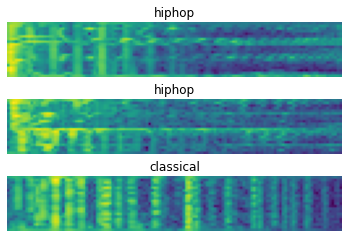

In [ ]:
# step 1


melgramtraindata = np.load('/content/drive/My Drive/HW3DATA/music_genre_data_di/train/melgrams/X.npy')
melgramtrainlabels = np.load("/content/drive/My Drive/HW3DATA/music_genre_data_di/train/melgrams/labels.npy")

melgramtestdata = np.load("/content/drive/My Drive/HW3DATA/music_genre_data_di/test/melgrams/X.npy")
melgramtestlabels = np.load("/content/drive/My Drive/HW3DATA/music_genre_data_di/test/melgrams/labels.npy")

melgramvaldata = np.load("/content/drive/My Drive/HW3DATA/music_genre_data_di/val/melgrams/X.npy")
melgramvallabels = np.load("/content/drive/My Drive/HW3DATA/music_genre_data_di/val/melgrams/labels.npy")


class melgramdataset(Dataset): #use opposite labels
  def __init__(self,data, labels,labels_map,transform=None, target_transform=None) -> None:
    self.transform = transform
    self.target_transform = target_transform
    self.melgramlabels = []
    for l in labels:
      self.melgramlabels.append(labels_map[l])
    self.melgramlabels = np.array(self.melgramlabels)
    self.melgramdata = data

  def __len__(self):
    return len(self.melgramlabels)

  def __getitem__(self, index):
    sound = self.melgramdata[index]
    label = self.melgramlabels[index]
    if self.transform:
      sound = self.transform(sound)
    if self.target_transform:
      label = self.target_transform(label)

    return sound, label

labels_map = {
    0: "classical",
    1: "blues",
    2: "rock_metal_hardrock",
    3: "hiphop",
}

opposite_labels_map = {
    "classical":0,
    "blues":1,
    "rock_metal_hardrock":2,
    "hiphop":3,
}

training_data = melgramdataset(melgramtraindata, melgramtrainlabels, opposite_labels_map, torch.tensor)
val_data = melgramdataset(melgramvaldata, melgramvallabels, opposite_labels_map, torch.tensor)
test_data = melgramdataset(melgramtestdata, melgramtestlabels, opposite_labels_map, torch.tensor)


import matplotlib.pyplot as plt


# visualization

sample_idx = torch.randint(len(training_data), size=(1,)).item()
img, label = training_data[sample_idx]
plt.subplot(3,1,1)
plt.title(labels_map[label])
plt.axis("off")
plt.imshow(img.squeeze())


sample_idx = torch.randint(len(test_data), size=(1,)).item()
img, label = test_data[sample_idx]
plt.subplot(3,1,2)
plt.title(labels_map[label])
plt.axis("off")
plt.imshow(img.squeeze())


sample_idx = torch.randint(len(val_data), size=(1,)).item()
img, label = val_data[sample_idx]
plt.subplot(3,1,3)
plt.title(labels_map[label])
plt.axis("off")
plt.imshow(img.squeeze())

train_dataloader = DataLoader(training_data, batch_size=16,shuffle=True )
val_dataloader =  DataLoader(val_data, batch_size=800 ,shuffle=True )
test_dataloader =  DataLoader(test_data, batch_size=1376 ,shuffle=False )

In [ ]:
# step 2

device = 'cuda' if torch.cuda.is_available() else 'cpu'

class LeNet(nn.Module):
  def __init__(self) -> None:
      super(LeNet, self).__init__()
      self.convolution_layer = nn.Sequential(
          nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2),
          nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2),
          nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2),
          nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2),
      )

      self.linear_relu_stack = nn.Sequential(
          nn.Linear(1024, 1024),
          nn.ReLU(),
          nn.Linear(1024, 256),
          nn.ReLU(),
          nn.Linear(256,32),
          nn.ReLU(),
          nn.Linear(32,4),
      )

  def forward(self, x):
    x = self.convolution_layer(x)
    x = torch.flatten(x,1)
    logits =  self.linear_relu_stack(x)
    return logits


model = LeNet().to(device)
print(model)

LeNet(
  (convolution_layer): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=32, bias=Tru

In [ ]:
# step 3 + 4


def testing(dataloader, costfunct, model):
  model.eval()
  test_loss = 0
  correct = 0
  size = len(dataloader.dataset)
  with torch.no_grad():
    for batch, (X,y) in enumerate(dataloader):
      X = X.to(device)
      y = y.to(device)
      X = torch.unsqueeze(X,1)
      pred = model(X)
      test_loss += costfunct(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  test_loss /= size
  correct /= size
  acc = 100*correct
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

  f1 = f1_score(pred, y, num_classes=4, average="macro")
  confmatrix = ConfusionMatrix(num_classes=4).to(device)
  print(f"f1 score is: {f1.item()}\n the confusion matrix is:")
  print(confmatrix(pred.argmax(1), y))
  model.train()
  return test_loss, f1, acc, confmatrix


def training_with_validation(epochs, optimizer, dataloader, validationdata,costfunct, model):
  bestmodel = None 
  bestf1 = -1
  bestepoch = -1
  size = len(dataloader.dataset)
  for ep in range(epochs):
    print(f"current epoch: {ep}\n")
    for batch, (X,y) in enumerate(dataloader):
      X = X.to(device)
      y = y.to(device)
      X = torch.unsqueeze(X,1)
      pred = model(X)
      loss = costfunct(pred,y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    print()
    tl,f1, acc, conf = testing(validationdata, costfunct, model)
    if f1 > bestf1:
      bestmodel = model 
      bestf1 = f1
      bestepoch = ep

  print(f"best epoch is: {bestepoch}")
  return bestmodel


costfun = nn.CrossEntropyLoss()
learning_rate = 0.002
num_epochs = 30
batch_size = 16
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

bestmodel = training_with_validation(num_epochs, optimizer, train_dataloader, val_dataloader, costfun, model)
print("TESTING THE BEST EPOCH\n\n")
testing(test_dataloader, costfun, bestmodel)

current epoch: 0


Test Error: 
 Accuracy: 40.9%, Avg loss: 0.001680 

f1 score is: 0.2872035503387451
 the confusion matrix is:
tensor([[142,   0,   0,  58],
        [ 52,   0,   0, 148],
        [ 15,   1,   0, 184],
        [ 14,   1,   0, 185]])
current epoch: 1


Test Error: 
 Accuracy: 41.1%, Avg loss: 0.001542 

f1 score is: 0.28692811727523804
 the confusion matrix is:
tensor([[145,   0,   0,  55],
        [ 55,   0,   0, 145],
        [ 19,   0,   0, 181],
        [ 16,   0,   0, 184]])
current epoch: 2


Test Error: 
 Accuracy: 42.9%, Avg loss: 0.001526 

f1 score is: 0.4033478796482086
 the confusion matrix is:
tensor([[ 79,  86,   0,  35],
        [ 11,  89,  11,  89],
        [  3,  35,  22, 140],
        [  1,  37,   9, 153]])
current epoch: 3


Test Error: 
 Accuracy: 42.5%, Avg loss: 0.001431 

f1 score is: 0.3033977150917053
 the confusion matrix is:
tensor([[150,   4,   0,  46],
        [ 55,   3,   0, 142],
        [ 19,   1,   0, 180],
        [ 11,   2,   0, 187]])

(0.0005872668048670126, tensor(0.6789), 67.07848837209302, ConfusionMatrix())

Without pooling and padding we have way too many weights to calculate making the process increadebly slow and decreasing accuracy.
 
With those 2 additions the weights to be calculated are decreased significantly. We managed to achieve upwards of 71.2% accuracy on the training set, and using the best epoch found with the validation set, we managed to reach Accuracy: 60.5%, Avg loss: 0.000675 f1 score: 0.6041808724403381

In [ ]:
# step 5

costfun = nn.CrossEntropyLoss()
learning_rate = 0.002
num_epochs = 30
batch_size = 16

execute = False

if execute:

  model_Adadelta = LeNet().to(device)
  optimizer = torch.optim.Adadelta(model_Adadelta.parameters(), lr = learning_rate)
  bestmodel = training_with_validation(num_epochs, optimizer, train_dataloader, val_dataloader, costfun, model_Adadelta)
  print("TESTING THE BEST EPOCH\n\n")
  test_loss, f1_Adadelta, acc_Adadelta, confmatrix = testing(test_dataloader, costfun, bestmodel)

  model_Adagrad = LeNet().to(device)
  optimizer = torch.optim.Adagrad(model_Adagrad.parameters(), lr = learning_rate)
  bestmodel = training_with_validation(num_epochs, optimizer, train_dataloader, val_dataloader, costfun, model_Adagrad)
  print("TESTING THE BEST EPOCH\n\n")
  test_loss, f1_Adagrad, acc_Adagrad, confmatrix = testing(test_dataloader, costfun, bestmodel)

  model_Adam = LeNet().to(device)
  optimizer = torch.optim.Adam(model_Adam.parameters(), lr = learning_rate)
  bestmodel = training_with_validation(num_epochs, optimizer, train_dataloader, val_dataloader, costfun, model_Adam)
  print("TESTING THE BEST EPOCH\n\n")
  test_loss, f1_Adam, acc_Adam, confmatrix = testing(test_dataloader, costfun, bestmodel)

  model_AdamW = LeNet().to(device)
  optimizer = torch.optim.AdamW(model_AdamW.parameters(), lr = learning_rate)
  bestmodel = training_with_validation(num_epochs, optimizer, train_dataloader, val_dataloader, costfun, model_AdamW)
  print("TESTING THE BEST EPOCH\n\n")
  test_loss, f1_AdamW, acc_AdamW, confmatrix = testing(test_dataloader, costfun, bestmodel)


  model_Adamax = LeNet().to(device)
  optimizer = torch.optim.Adamax(model_Adamax.parameters(), lr = learning_rate)
  bestmodel = training_with_validation(num_epochs, optimizer, train_dataloader, val_dataloader, costfun, model_Adamax)
  print("TESTING THE BEST EPOCH\n\n")
  test_loss, f1_Adamax, acc_Adamax, confmatrix = testing(test_dataloader, costfun, bestmodel)

  model_ASGD = LeNet().to(device)
  optimizer = torch.optim.ASGD(model_ASGD.parameters(), lr = learning_rate)
  bestmodel = training_with_validation(num_epochs, optimizer, train_dataloader, val_dataloader, costfun, model_ASGD)
  print("TESTING THE BEST EPOCH\n\n")
  test_loss, f1_ASGD, acc_ASGD, confmatrix = testing(test_dataloader, costfun, bestmodel)


  model_NAdam = LeNet().to(device)
  optimizer = torch.optim.NAdam(model_NAdam.parameters(), lr = learning_rate)
  bestmodel = training_with_validation(num_epochs, optimizer, train_dataloader, val_dataloader, costfun, model_NAdam)
  print("TESTING THE BEST EPOCH\n\n")
  test_loss, f1_NAdam, acc_NAdam, confmatrix = testing(test_dataloader, costfun, bestmodel)

  model_RAdam = LeNet().to(device)
  optimizer = torch.optim.RAdam(model_RAdam.parameters(), lr = learning_rate)
  bestmodel = training_with_validation(num_epochs, optimizer, train_dataloader, val_dataloader, costfun, model_RAdam)
  print("TESTING THE BEST EPOCH\n\n")
  test_loss, f1_RAdam, acc_RAdam, confmatrix = testing(test_dataloader, costfun, bestmodel)

  model_RMSprop = LeNet().to(device)
  optimizer = torch.optim.RMSprop(model_RMSprop.parameters(), lr = learning_rate)
  bestmodel = training_with_validation(num_epochs, optimizer, train_dataloader, val_dataloader, costfun, model_RMSprop)
  print("TESTING THE BEST EPOCH\n\n")
  test_loss, f1_RMSprop, acc_RMSprop, confmatrix = testing(test_dataloader, costfun, bestmodel)

  model_Rprop = LeNet().to(device)
  optimizer = torch.optim.Rprop(model_Rprop.parameters(), lr = learning_rate)
  bestmodel = training_with_validation(num_epochs, optimizer, train_dataloader, val_dataloader, costfun, model_Rprop)
  print("TESTING THE BEST EPOCH\n\n")
  test_loss, f1_Rprop, acc_Rprop, confmatrix = testing(test_dataloader, costfun, bestmodel)

  model_SGD = LeNet().to(device)
  optimizer = torch.optim.SGD(model_SGD.parameters(), lr = learning_rate)
  bestmodel = training_with_validation(num_epochs, optimizer, train_dataloader, val_dataloader, costfun, model_SGD)
  print("TESTING THE BEST EPOCH\n\n")
  test_loss, f1_SGD, acc_SGD, confmatrix = testing(test_dataloader, costfun, bestmodel)


  print(f"Algorithm: Adadelta, accuracy is {acc_Adadelta} and f1 score is{f1_Adadelta}")
  print(f"Algorithm: Adagrad, accuracy is {acc_Adagrad} and f1 score is{f1_Adagrad}")
  print(f"Algorithm: Adam, accuracy is {acc_Adam} and f1 score is{f1_Adam}")
  print(f"Algorithm: AdamW, accuracy is {acc_AdamW} and f1 score is{f1_AdamW}")
  print(f"Algorithm: Adamax, accuracy is {acc_Adamax} and f1 score is{f1_Adamax}")
  print(f"Algorithm: ASGD, accuracy is {acc_ASGD} and f1 score is{f1_ASGD}")
  print(f"Algorithm: NAdam, accuracy is {acc_NAdam} and f1 score is{f1_NAdam}")
  print(f"Algorithm: RAdam, accuracy is {acc_RAdam} and f1 score is{f1_RAdam}")
  print(f"Algorithm: RMSprop, accuracy is {acc_RMSprop} and f1 score is{f1_RMSprop}")
  print(f"Algorithm: Rprop, accuracy is {acc_Rprop} and f1 score is{f1_Rprop}")
  print(f"Algorithm: SGD, accuracy is {acc_SGD} and f1 score is{f1_SGD}")

current epoch: 0


Test Error: 
 Accuracy: 43.8%, Avg loss: 0.001727 

f1 score is: 0.3563973307609558
 the confusion matrix is:
tensor([[185,   2,   0,  13],
        [138,  34,   0,  28],
        [111,  75,   0,  14],
        [ 51,  18,   0, 131]])
current epoch: 1


Test Error: 
 Accuracy: 42.2%, Avg loss: 0.001721 

f1 score is: 0.2822229266166687
 the confusion matrix is:
tensor([[161,   0,   0,  39],
        [118,   0,   0,  82],
        [114,   0,   0,  86],
        [ 23,   0,   0, 177]])
current epoch: 2


Test Error: 
 Accuracy: 40.8%, Avg loss: 0.001716 

f1 score is: 0.28803834319114685
 the confusion matrix is:
tensor([[131,   0,   0,  69],
        [ 32,   0,   0, 168],
        [ 23,   0,   0, 177],
        [  5,   0,   0, 195]])
current epoch: 3


Test Error: 
 Accuracy: 40.1%, Avg loss: 0.001710 

f1 score is: 0.28794679045677185
 the confusion matrix is:
tensor([[125,   0,   0,  75],
        [ 25,   0,   0, 175],
        [ 13,   0,   0, 187],
        [  4,   0,   0, 196]]

Algorithm: Adadelta, accuracy is 48.11046511627907 and f1 score is 0.4658815860748291   

Algorithm: Adagrad, accuracy is 74.8546511627907 and f1 score is 0.75447678565979

Algorithm: Adam, accuracy is 68.09593023255815 and f1 score is 0.6798825263977051 

Algorithm: AdamW, accuracy is 63.735465116279066 and f1 score is 0.64720618724823 

Algorithm: Adamax, accuracy is 72.4563953488372 and f1 score is 0.7297154664993286 

Algorithm: ASGD, accuracy is 66.35174418604652 and f1 score is 0.6590175032615662 

Algorithm: NAdam, accuracy is 58.06686046511628 and f1 score is 0.5827581882476807 

Algorithm: RAdam, accuracy is 66.06104651162791 and f1 score is 0.6476108431816101 

Algorithm: RMSprop, accuracy is 70.20348837209302 and f1 score is 0.711538553237915 

Algorithm: Rprop, accuracy is 62.28197674418605 and f1 score is 0.6215466260910034 

Algorithm: SGD, accuracy is 63.95348837209303 and f1 score is 0.648705244064331 

runtime 1h 43m 37s

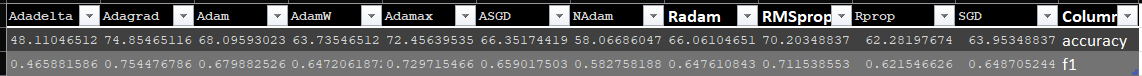


We can see wild diffrences in the accuracy and f1 score, just by changing the optimiser. The best result was achieved using Adagrad and the worst with Adadelta. From the results we got, we can conclude that choosing the correct optimiser is exxtremely important.

**QUESTION 3**

In [ ]:

import time
import torch
import os, random
from google.colab import drive
import numpy as np 
from torchvision import datasets 
from torchvision.transforms import ToTensor
import torch.nn as nn 
import torch.nn.functional as F 
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%pip install torchmetrics
from torchmetrics.functional import f1_score
from torchmetrics import ConfusionMatrix
drive.mount('/content/drive')
torch.use_deterministic_algorithms(True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# step 1
melgramtraindata = np.load('/content/drive/My Drive/HW3DATA/music_genre_data_di/train/melgrams/X.npy')
melgramtrainlabels = np.load("/content/drive/My Drive/HW3DATA/music_genre_data_di/train/melgrams/labels.npy")

melgramtestdata = np.load("/content/drive/My Drive/HW3DATA/music_genre_data_di/test/melgrams/X.npy")
melgramtestlabels = np.load("/content/drive/My Drive/HW3DATA/music_genre_data_di/test/melgrams/labels.npy")

melgramvaldata = np.load("/content/drive/My Drive/HW3DATA/music_genre_data_di/val/melgrams/X.npy")
melgramvallabels = np.load("/content/drive/My Drive/HW3DATA/music_genre_data_di/val/melgrams/labels.npy")


def torch_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

torch_seed(seed=0)

class melgramdataset(Dataset): #use opposite labels
  def __init__(self,data, labels,labels_map,transform=None, target_transform=None) -> None:
    self.transform = transform
    self.target_transform = target_transform
    self.melgramlabels = []
    for l in labels:
      self.melgramlabels.append(labels_map[l])
    self.melgramlabels = np.array(self.melgramlabels)
    self.melgramdata = data

  def __len__(self):
    return len(self.melgramlabels)

  def __getitem__(self, index):
    sound = self.melgramdata[index]
    label = self.melgramlabels[index]
    if self.transform:
      sound = self.transform(sound)
    if self.target_transform:
      label = self.target_transform(label)

    return sound, label

labels_map = {
    0: "classical",
    1: "blues",
    2: "rock_metal_hardrock",
    3: "hiphop",
}

opposite_labels_map = {
    "classical":0,
    "blues":1,
    "rock_metal_hardrock":2,
    "hiphop":3,
}

training_data = melgramdataset(melgramtraindata, melgramtrainlabels, opposite_labels_map, torch.tensor)
val_data = melgramdataset(melgramvaldata, melgramvallabels, opposite_labels_map, torch.tensor)
test_data = melgramdataset(melgramtestdata, melgramtestlabels, opposite_labels_map, torch.tensor)

train_dataloader = DataLoader(training_data, batch_size=16,shuffle=True )
val_dataloader =  DataLoader(val_data, batch_size=800 ,shuffle=True )
test_dataloader =  DataLoader(test_data, batch_size=1376 ,shuffle=False )


device = 'cuda' if torch.cuda.is_available() else 'cpu'

class LeNet(nn.Module):
  def __init__(self) -> None:
      super(LeNet, self).__init__()
      self.convolution_layer = nn.Sequential(
          nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),
          nn.CELU(),
          nn.MaxPool2d(kernel_size=2),
          nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2),
          nn.CELU(),
          nn.MaxPool2d(kernel_size=2),
          nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2),
          nn.CELU(),
          nn.MaxPool2d(kernel_size=2),
          nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2),
          nn.CELU(),
          nn.MaxPool2d(kernel_size=2),
      )

      self.linear_relu_stack = nn.Sequential(
          nn.Linear(1024, 1024),
          nn.CELU(),
          nn.Linear(1024, 256),
          nn.CELU(),
          nn.Linear(256,32),
          nn.CELU(),
          nn.Linear(32,4),
      )

  def forward(self, x):
    x = self.convolution_layer(x)
    x = torch.flatten(x,1)
    logits =  self.linear_relu_stack(x)
    return logits


model = LeNet().to(device)
print(model)

def testing(dataloader, costfunct, model):
  test_loss = 0
  correct = 0
  size = len(dataloader.dataset)
  model.eval()
  with torch.no_grad():
    for batch, (X,y) in enumerate(dataloader):
      X = X.to(device)
      y = y.to(device)
      X = torch.unsqueeze(X,1)
      pred = model(X)
      test_loss += costfunct(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  test_loss /= size
  correct /= size
  acc = 100*correct

  f1 = f1_score(pred, y, num_classes=4, average="macro")
  confmatrix = ConfusionMatrix(num_classes=4).to(device)
  model.train()
  return test_loss, f1, acc, confmatrix


def training_with_validation(epochs, optimizer, dataloader, validationdata,costfunct, model):
  
  bestmodel = None 
  bestf1 = -1
  bestepoch = -1⁸
  size = len(dataloader.dataset)
  for ep in range(epochs):
    for batch, (X,y) in enumerate(dataloader):
      X = X.to(device)
      y = y.to(device)
      X = torch.unsqueeze(X,1)
      pred = model(X)
      loss = costfunct(pred,y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    tl,f1, acc, conf = testing(validationdata, costfunct, model)
    if f1 > bestf1:
      bestmodel = model 
      bestf1 = f1
      bestepoch = ep
  return bestmodel

LeNet(
  (convolution_layer): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): CELU(alpha=1.0)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): CELU(alpha=1.0)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): CELU(alpha=1.0)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (10): CELU(alpha=1.0)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): CELU(alpha=1.0)
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): CELU(alpha=1.0)
    

In [ ]:
costfun = nn.CrossEntropyLoss()
learning_rate = 0.002
num_epochs = 30
batch_size = 16
model = LeNet().to(device)
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)
bestmodel = training_with_validation(num_epochs, optimizer, train_dataloader, val_dataloader, costfun, model)
test_loss, f1, acc, confmatrix = testing(test_dataloader, costfun, bestmodel)
print(f"test loss is: {test_loss}, f1 score is: {f1}, accuracy is: {acc}")

test loss is: 0.001011837447105452, f1 score is: 0.7710870504379272, accuracy is: 76.88953488372093


test loss is: 0.001011837447105452, f1 score is: 0.7710870504379272, accuracy is: 76.88953488372093




In [ ]:
execute = False



class LeNetwithfun(nn.Module):
  def __init__(self, fun) -> None:
      super(LeNetwithfun, self).__init__()
      self.convolution_layer = nn.Sequential(
          nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),
          fun(),
          nn.MaxPool2d(kernel_size=2),
          nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2),
          fun(),
          nn.MaxPool2d(kernel_size=2),
          nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2),
          fun(),
          nn.MaxPool2d(kernel_size=2),
          nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2),
          fun(),
          nn.MaxPool2d(kernel_size=2),
      )

      self.linear_relu_stack = nn.Sequential(
          nn.Linear(1024, 1024),
          fun(),
          nn.Linear(1024, 256),
          fun(),
          nn.Linear(256,32),
          fun(),
          nn.Linear(32,4),
      )

  def forward(self, x):
    x = self.convolution_layer(x)
    x = torch.flatten(x,1)
    logits =  self.linear_relu_stack(x)
    return logits


costfun = nn.CrossEntropyLoss()
learning_rate = 0.002
num_epochs = 30
batch_size = 16


if execute:
  model = LeNetwithfun(nn.ELU).to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate) #using SGD because it is faster
  bestmodel = training_with_validation(num_epochs, optimizer, train_dataloader, val_dataloader, costfun, model)
  print("TESTING THE BEST EPOCH\n\n")
  test_loss, f1_ELU, acc_ELU, confmatrix = testing(test_dataloader, costfun, bestmodel)
  
  model = LeNetwithfun(nn.Hardshrink).to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate) #using SGD because it is faster
  bestmodel = training_with_validation(num_epochs, optimizer, train_dataloader, val_dataloader, costfun, model)
  print("TESTING THE BEST EPOCH\n\n")
  test_loss, f1_Hardshrink, acc_Hardshrink, confmatrix = testing(test_dataloader, costfun, bestmodel)
  
  model = LeNetwithfun(nn.Hardsigmoid).to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate) #using SGD because it is faster
  bestmodel = training_with_validation(num_epochs, optimizer, train_dataloader, val_dataloader, costfun, model)
  print("TESTING THE BEST EPOCH\n\n")
  test_loss, f1_Hardsigmoid, acc_Hardsigmoid, confmatrix = testing(test_dataloader, costfun, bestmodel)

  model = LeNetwithfun(nn.Hardtanh).to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate) #using SGD because it is faster
  bestmodel = training_with_validation(num_epochs, optimizer, train_dataloader, val_dataloader, costfun, model)
  print("TESTING THE BEST EPOCH\n\n")
  test_loss, f1_Hardtanh, acc_Hardtanh, confmatrix = testing(test_dataloader, costfun, bestmodel)
  
  model = LeNetwithfun(nn.Hardswish).to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate) #using SGD because it is faster
  bestmodel = training_with_validation(num_epochs, optimizer, train_dataloader, val_dataloader, costfun, model)
  print("TESTING THE BEST EPOCH\n\n")
  test_loss, f1_Hardswish, acc_Hardswish, confmatrix = testing(test_dataloader, costfun, bestmodel)

  model = LeNetwithfun(nn.LeakyReLU).to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate) #using SGD because it is faster
  bestmodel = training_with_validation(num_epochs, optimizer, train_dataloader, val_dataloader, costfun, model)
  print("TESTING THE BEST EPOCH\n\n")
  test_loss, f1_LeakyReLU, acc_LeakyReLU, confmatrix = testing(test_dataloader, costfun, bestmodel)
  
  model = LeNetwithfun(nn.LogSigmoid).to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate) #using SGD because it is faster
  bestmodel = training_with_validation(num_epochs, optimizer, train_dataloader, val_dataloader, costfun, model)
  print("TESTING THE BEST EPOCH\n\n")
  test_loss, f1_LogSigmoid, acc_LogSigmoid, confmatrix = testing(test_dataloader, costfun, bestmodel)
  
  model = LeNetwithfun(nn.PReLU).to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate) #using SGD because it is faster
  bestmodel = training_with_validation(num_epochs, optimizer, train_dataloader, val_dataloader, costfun, model)
  print("TESTING THE BEST EPOCH\n\n")
  test_loss, f1_PReLU, acc_PReLU, confmatrix = testing(test_dataloader, costfun, bestmodel)
  
  model = LeNetwithfun(nn.ReLU).to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate) #using SGD because it is faster
  bestmodel = training_with_validation(num_epochs, optimizer, train_dataloader, val_dataloader, costfun, model)
  print("TESTING THE BEST EPOCH\n\n")
  test_loss, f1_ReLU, acc_ReLU, confmatrix = testing(test_dataloader, costfun, bestmodel)
  
  model = LeNetwithfun(nn.ReLU6).to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate) #using SGD because it is faster
  bestmodel = training_with_validation(num_epochs, optimizer, train_dataloader, val_dataloader, costfun, model)
  print("TESTING THE BEST EPOCH\n\n")
  test_loss, f1_ReLU6, acc_ReLU6, confmatrix = testing(test_dataloader, costfun, bestmodel)
  
  model = LeNetwithfun(nn.RReLU).to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate) #using SGD because it is faster
  bestmodel = training_with_validation(num_epochs, optimizer, train_dataloader, val_dataloader, costfun, model)
  print("TESTING THE BEST EPOCH\n\n")
  test_loss, f1_RReLU, acc_RReLU, confmatrix = testing(test_dataloader, costfun, bestmodel)
  
  model = LeNetwithfun(nn.SELU).to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate) #using SGD because it is faster
  bestmodel = training_with_validation(num_epochs, optimizer, train_dataloader, val_dataloader, costfun, model)
  print("TESTING THE BEST EPOCH\n\n")
  test_loss, f1_SELU, acc_SELU, confmatrix = testing(test_dataloader, costfun, bestmodel)
  
  model = LeNetwithfun(nn.CELU).to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate) #using SGD because it is faster
  bestmodel = training_with_validation(num_epochs, optimizer, train_dataloader, val_dataloader, costfun, model)
  print("TESTING THE BEST EPOCH\n\n")
  test_loss, f1_CELU, acc_CELU, confmatrix = testing(test_dataloader, costfun, bestmodel)
  
  model = LeNetwithfun(nn.GELU).to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate) #using SGD because it is faster
  bestmodel = training_with_validation(num_epochs, optimizer, train_dataloader, val_dataloader, costfun, model)
  print("TESTING THE BEST EPOCH\n\n")
  test_loss, f1_GELU, acc_GELU, confmatrix = testing(test_dataloader, costfun, bestmodel)
  
  model = LeNetwithfun(nn.Sigmoid).to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate) #using SGD because it is faster
  bestmodel = training_with_validation(num_epochs, optimizer, train_dataloader, val_dataloader, costfun, model)
  print("TESTING THE BEST EPOCH\n\n")
  test_loss, f1_Sigmoid, acc_Sigmoid, confmatrix = testing(test_dataloader, costfun, bestmodel)
  
  model = LeNetwithfun(nn.SiLU).to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate) #using SGD because it is faster
  bestmodel = training_with_validation(num_epochs, optimizer, train_dataloader, val_dataloader, costfun, model)
  print("TESTING THE BEST EPOCH\n\n")
  test_loss, f1_SiLU, acc_SiLU, confmatrix = testing(test_dataloader, costfun, bestmodel)
  
  model = LeNetwithfun(nn.Mish).to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate) #using SGD because it is faster
  bestmodel = training_with_validation(num_epochs, optimizer, train_dataloader, val_dataloader, costfun, model)
  print("TESTING THE BEST EPOCH\n\n")
  test_loss, f1_Mish, acc_Mish, confmatrix = testing(test_dataloader, costfun, bestmodel)
  
  model = LeNetwithfun(nn.Softplus).to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate) #using SGD because it is faster
  bestmodel = training_with_validation(num_epochs, optimizer, train_dataloader, val_dataloader, costfun, model)
  print("TESTING THE BEST EPOCH\n\n")
  test_loss, f1_Softplus, acc_Softplus, confmatrix = testing(test_dataloader, costfun, bestmodel)
  
  model = LeNetwithfun(nn.Softshrink).to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate) #using SGD because it is faster
  bestmodel = training_with_validation(num_epochs, optimizer, train_dataloader, val_dataloader, costfun, model)
  print("TESTING THE BEST EPOCH\n\n")
  test_loss, f1_Softshrink, acc_Softshrink, confmatrix = testing(test_dataloader, costfun, bestmodel)
  
  model = LeNetwithfun(nn.Softsign).to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate) #using SGD because it is faster
  bestmodel = training_with_validation(num_epochs, optimizer, train_dataloader, val_dataloader, costfun, model)
  print("TESTING THE BEST EPOCH\n\n")
  test_loss, f1_Softsign, acc_Softsign, confmatrix = testing(test_dataloader, costfun, bestmodel)
  
  model = LeNetwithfun(nn.Tanh).to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate) #using SGD because it is faster
  bestmodel = training_with_validation(num_epochs, optimizer, train_dataloader, val_dataloader, costfun, model)
  print("TESTING THE BEST EPOCH\n\n")
  test_loss, f1_Tanh, acc_Tanh, confmatrix = testing(test_dataloader, costfun, bestmodel)
  
  model = LeNetwithfun(nn.Tanhshrink).to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate) #using SGD because it is faster
  bestmodel = training_with_validation(num_epochs, optimizer, train_dataloader, val_dataloader, costfun, model)
  print("TESTING THE BEST EPOCH\n\n")
  test_loss, f1_Tanhshrink, acc_Tanhshrink, confmatrix = testing(test_dataloader, costfun, bestmodel)
  
  print(f"Algorithm: ELU, accuracy is {acc_ELU} and f1 score is{f1_ELU}")
  print(f"Algorithm: Hardshrink, accuracy is {acc_Hardshrink} and f1 score is{f1_Hardshrink}")
  print(f"Algorithm: Hardsigmoid, accuracy is {acc_Hardsigmoid} and f1 score is{f1_Hardsigmoid}")
  print(f"Algorithm: Hardtanh, accuracy is {acc_Hardtanh} and f1 score is{f1_Hardtanh}")
  print(f"Algorithm: Hardswish, accuracy is {acc_Hardswish} and f1 score is{f1_Hardswish}")
  print(f"Algorithm: LeakyReLU, accuracy is {acc_LeakyReLU} and f1 score is{f1_LeakyReLU}")
  print(f"Algorithm: LogSigmoid, accuracy is {acc_LogSigmoid} and f1 score is{f1_LogSigmoid}")
  print(f"Algorithm: PReLU, accuracy is {acc_PReLU} and f1 score is{f1_PReLU}")
  print(f"Algorithm: ReLU, accuracy is {acc_ReLU} and f1 score is{f1_ReLU}")
  print(f"Algorithm: ReLU6, accuracy is {acc_ReLU6} and f1 score is{f1_ReLU6}")
  print(f"Algorithm: RReLU, accuracy is {acc_RReLU} and f1 score is{f1_RReLU}")
  print(f"Algorithm: SELU, accuracy is {acc_SELU} and f1 score is{f1_SELU}")
  print(f"Algorithm: CELU, accuracy is {acc_CELU} and f1 score is{f1_CELU}")
  print(f"Algorithm: GELU, accuracy is {acc_GELU} and f1 score is{f1_GELU}")
  print(f"Algorithm: Sigmoid, accuracy is {acc_Sigmoid} and f1 score is{f1_Sigmoid}")
  print(f"Algorithm: SiLU, accuracy is {acc_SiLU} and f1 score is{f1_SiLU}")
  print(f"Algorithm: Mish, accuracy is {acc_Mish} and f1 score is{f1_Mish}")
  print(f"Algorithm: Softplus, accuracy is {acc_Softplus} and f1 score is{f1_Softplus}")
  print(f"Algorithm: Softshrink, accuracy is {acc_Softshrink} and f1 score is{f1_Softshrink}")
  print(f"Algorithm: Softsign, accuracy is {acc_Softsign} and f1 score is{f1_Softsign}")
  print(f"Algorithm: Tanh, accuracy is {acc_Tanh} and f1 score is{f1_Tanh}")
  print(f"Algorithm: Tanhshrink, accuracy is {acc_Tanhshrink} and f1 score is{f1_Tanhshrink}")
 
  

Algorithm: ELU, accuracy is 71.36627906976744 and f1 score is 0.7176399230957031

Algorithm: Hardshrink, accuracy is 72.60174418604652 and f1 score is 0.7265828847885132

Algorithm: Hardsigmoid, accuracy is 23.546511627906977 and f1 score is 0.09529411792755127

Algorithm: Hardtanh, accuracy is 56.25 and f1 score is 0.5464939475059509

Algorithm: Hardswish, accuracy is 71.2936046511628 and f1 score is 0.7253984808921814

Algorithm: LeakyReLU, accuracy is 67.15116279069767 and f1 score is 0.6638474464416504

Algorithm: LogSigmoid, accuracy is 39.098837209302324 and f1 score is 0.2722686529159546

Algorithm: PReLU, accuracy is 69.04069767441861 and f1 score is 0.6988807916641235

Algorithm: ReLU, accuracy is 56.83139534883721 and f1 score is 0.5654309391975403

Algorithm: ReLU6, accuracy is 44.622093023255815 and f1 score is 0.42181751132011414

Algorithm: RReLU, accuracy is 65.26162790697676 and f1 score is 0.6531794667243958

Algorithm: SELU, accuracy is 73.54651162790698 and f1 score is 0.7299819588661194

Algorithm: CELU, accuracy is 74.12790697674419 and f1 score is 0.7502588033676147

Algorithm: GELU, accuracy is 73.98255813953489 and f1 score is 0.743916928768158

Algorithm: Sigmoid, accuracy is 23.546511627906977 and f1 score is 0.09529411792755127

Algorithm: SiLU, accuracy is 72.23837209302324 and f1 score is 0.7225213050842285

Algorithm: Mish, accuracy is 69.3313953488372 and f1 score is 0.6946865916252136

Algorithm: Softplus, accuracy is 69.04069767441861 and f1 score is 0.6950930953025818

Algorithm: Softshrink, accuracy is 28.997093023255815 and f1 score is 0.11239437013864517

Algorithm: Softsign, accuracy is 35.61046511627907 and f1 score is 0.3194787800312042 

Algorithm: Tanh, accuracy is 52.8343023255814 and f1 score is 0.4770197868347168

Algorithm: Tanhshrink, accuracy is 28.997093023255815 and f1 score is 0.11258465051651001


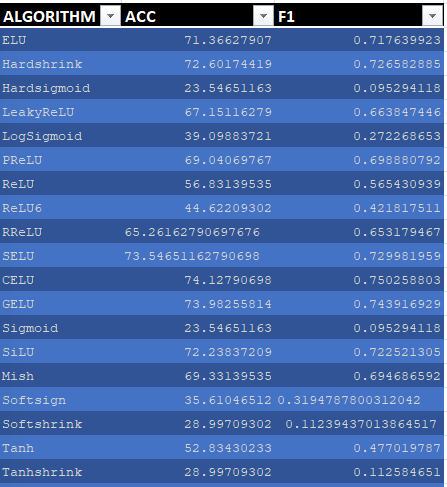

In [ ]:
# step 4


def training_with_scheduler(epochs, optimizer, dataloader, validationdata,costfunct, model, scheduler):
  
  bestmodel = None 
  bestf1 = -1
  bestepoch = -1
  size = len(dataloader.dataset)
  for ep in range(epochs):
    for batch, (X,y) in enumerate(dataloader):
      X = X.to(device)
      y = y.to(device)
      X = torch.unsqueeze(X,1)
      pred = model(X)
      loss = costfunct(pred,y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    
    tl,f1, acc, conf = testing(validationdata, costfunct, model)
    if f1 > bestf1:
      bestmodel = model 
      bestf1 = f1
      bestepoch = ep
    
    scheduler.step()

  return bestmodel

costfun = nn.CrossEntropyLoss()
learning_rate = 0.002
num_epochs = 30
batch_size = 16
model = LeNet().to(device)
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate) 

# lr_lambda = lambda epoch : epoch/10
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda, verbose=True)
# bestmodel = training_with_scheduler(num_epochs, optimizer, train_dataloader, val_dataloader, costfun, model, scheduler)
# test_loss, f1_, acc_, confmatrix = testing(test_dataloader, costfun, bestmodel)
# print(f"Algorithm: LambdaLR, accuracy is {acc_} and f1 score is {f1_}")

# lr_lambda = lambda epoch: 0.95
# scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda, verbose=True)
# bestmodel = training_with_scheduler(num_epochs, optimizer, train_dataloader, val_dataloader, costfun, model, scheduler)
# test_loss, f1_, acc_, confmatrix = testing(test_dataloader, costfun, bestmodel)
# print(f"Algorithm: MultiplicativeLR, accuracy is {acc_} and f1 score is {f1_}")

# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, verbose=True)
# bestmodel = training_with_scheduler(num_epochs, optimizer, train_dataloader, val_dataloader, costfun, model, scheduler)
# test_loss, f1_, acc_, confmatrix = testing(test_dataloader, costfun, bestmodel)
# print(f"Algorithm: StepLR, accuracy is {acc_} and f1 score is {f1_}")

# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,20], verbose=True)
# bestmodel = training_with_scheduler(num_epochs, optimizer, train_dataloader, val_dataloader, costfun, model, scheduler)
# test_loss, f1_, acc_, confmatrix = testing(test_dataloader, costfun, bestmodel)
# print(f"Algorithm: MultiStepLR, accuracy is {acc_} and f1 score is {f1_}")

# scheduler = torch.optim.lr_scheduler.ConstantLR(optimizer, verbose=True)
# bestmodel = training_with_scheduler(num_epochs, optimizer, train_dataloader, val_dataloader, costfun, model, scheduler)
# test_loss, f1_, acc_, confmatrix = testing(test_dataloader, costfun, bestmodel)
# print(f"Algorithm: ConstantLR, accuracy is {acc_} and f1 score is {f1_}")

# scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, verbose=True)
# bestmodel = training_with_scheduler(num_epochs, optimizer, train_dataloader, val_dataloader, costfun, model, scheduler)
# test_loss, f1_1, acc_1, confmatrix = testing(test_dataloader, costfun, bestmodel)
# print(f"Algorithm: LinearLR, accuracy is {acc_} and f1 score is {f1_}")

# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999, verbose=True)
# bestmodel = training_with_scheduler(num_epochs, optimizer, train_dataloader, val_dataloader, costfun, model, scheduler)
# test_loss, f1_2, acc_2, confmatrix = testing(test_dataloader, costfun, bestmodel)
# print(f"Algorithm: ExponentialLR, accuracy is {acc_} and f1 score is {f1_}")

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, verbose=True)
# bestmodel = training_with_scheduler(num_epochs, optimizer, train_dataloader, val_dataloader, costfun, model, scheduler)
# test_loss, f1_3, acc_3, confmatrix = testing(test_dataloader, costfun, bestmodel)
# print(f"Algorithm: CosineAnnealingLR, accuracy is {acc_} and f1 score is {f1_}")

# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, verbose=True)
# bestmodel = training_with_scheduler(num_epochs, optimizer, train_dataloader, val_dataloader, costfun, model, scheduler)
# test_loss, f1_7, acc_7, confmatrix = testing(test_dataloader, costfun, bestmodel)
# print(f"Algorithm: CosineAnnealingWarmRestarts, accuracy is {acc_} and f1 score is {f1_}")


Algorithm: LambdaLR, accuracy is 72.4563953488372 and f1 score is 0.7266383171081543

Algorithm: MultiplicativeLR, accuracy is 75.79941860465115 and f1 score is 0.7606614828109741

Algorithm: StepLR, accuracy is 78.41569767441861 and f1 score is 0.7872134447097778

Algorithm: MultiStepLR, accuracy is 76.30813953488372 and f1 score is 0.7659837007522583

Algorithm: ConstantLR, accuracy is 74.63662790697676 and f1 score is 0.7512418031692505

Algorithm: LinearLR, accuracy is 76.30813953488372 and f1 score is 0.7670813202857971

Algorithm: ExponentialLR, accuracy is 76.16279069767442 and f1 score is 0.7657319903373718

Algorithm: CosineAnnealingLR, accuracy is 76.16279069767442 and f1 score is 0.7656395435333252

Algorithm: CosineAnnealingWarmRestarts, accuracy is 76.09011627906976 and f1 score is 0.7642688155174255

In [ ]:
# step 5

class LeNet_with_batchnorm2d(nn.Module):
  def __init__(self) -> None:
      super(LeNet_with_batchnorm2d, self).__init__()
      self.convolution_layer = nn.Sequential(
          nn.BatchNorm2d(1),
          nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),
          nn.CELU(),
          nn.MaxPool2d(kernel_size=2),
          nn.BatchNorm2d(16),
          nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2),
          nn.CELU(),
          nn.MaxPool2d(kernel_size=2),
          nn.BatchNorm2d(32),
          nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2),
          nn.CELU(),
          nn.MaxPool2d(kernel_size=2),
          nn.BatchNorm2d(64),
          nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2),
          nn.CELU(),
          nn.MaxPool2d(kernel_size=2),
      )

      self.linear_relu_stack = nn.Sequential(
          nn.Linear(1024, 1024),
          nn.CELU(),
          nn.Linear(1024, 256),
          nn.CELU(),
          nn.Linear(256,32),
          nn.CELU(),
          nn.Linear(32,4),
      )

  def forward(self, x):
    x = self.convolution_layer(x)
    x = torch.flatten(x,1)
    logits =  self.linear_relu_stack(x)
    return logits

In [ ]:
costfun = nn.CrossEntropyLoss()
learning_rate = 0.002
num_epochs = 30
batch_size = 16
model = LeNet_with_batchnorm2d().to(device)
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate) 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, verbose=True)
bestmodel = training_with_scheduler(num_epochs, optimizer, train_dataloader, val_dataloader, costfun, model, scheduler)
test_loss, f1_, acc_, confmatrix = testing(test_dataloader, costfun, bestmodel)


without batch normalization:Accuracy: 74.9%, Avg loss: 0.000682 f1 score is: 0.7530226707458496

with batch normalization:Accuracy: 76.3%, Avg loss: 0.000687 f1 score is: 0.7673460841178894

In [ ]:
# step 6

class LeNet_with_batchnormd(nn.Module):
  def __init__(self, per) -> None:
      super(LeNet_with_batchnormd, self).__init__()
      self.convolution_layer = nn.Sequential(
          nn.BatchNorm2d(1),
          nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),
          nn.CELU(),
          nn.MaxPool2d(kernel_size=2),
          nn.BatchNorm2d(16),
          nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2),
          nn.CELU(),
          nn.MaxPool2d(kernel_size=2),
          nn.BatchNorm2d(32),
          nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2),
          nn.CELU(),
          nn.MaxPool2d(kernel_size=2),
          nn.BatchNorm2d(64),
          nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2),
          nn.CELU(),
          nn.MaxPool2d(kernel_size=2),
      )

      self.linear_relu_stack = nn.Sequential(
          nn.Linear(1024, 1024),
          nn.Dropout(p=per),
          nn.CELU(),
          nn.Linear(1024, 256),
          nn.Dropout(p=per),
          nn.CELU(),
          nn.Linear(256,32),
          nn.Dropout(p=per),
          nn.CELU(),
          nn.Linear(32,4),
          nn.Dropout(p=per),
      )

  def forward(self, x):
    x = self.convolution_layer(x)
    x = torch.flatten(x,1)
    logits =  self.linear_relu_stack(x)
    return logits

costfun = nn.CrossEntropyLoss()
learning_rate = 0.002
num_epochs = 60
batch_size = 16


In [ ]:
for num_epochs in [30,60]:
print(f"epochs: {num_epochs}")
for (per,wd) in [(0.1,1e-8), (0.1,1e-5), (0.1,1e-3), (0.2,1e-8), (0.2,1e-5), (0.2,1e-3), (0.3,1e-8),(0.3,1e-5), (0.3,1e-3),(0.4,1e-8), (0.4,1e-5), (0.4,1e-3)]:
  model = LeNet_with_batchnormd(per).to(device)
  optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate, weight_decay= wd) 
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10)
  bestmodel = training_with_scheduler(num_epochs, optimizer, train_dataloader, val_dataloader, costfun, model, scheduler)
  test_loss, f1_t, acc_t, confmatrix = testing(test_dataloader, costfun, bestmodel)
  test_loss, f1_v, acc_v, confmatrix = testing(val_dataloader, costfun, bestmodel)
  print(f"For weight decay = {wd} and dropout = {per} we got:Accuracy for test: {acc_t}, f1 score for test: {f1_t}, Accuracy for val: {acc_v}, f1 score for val: {f1_v}")

**No combinations:**

**30 EPOCHS**:

For weight decay = 1e-08 and dropout = 0 we got:Accuracy for test: 76.96220930232558, f1 score for test: 0.7719160318374634, Accuracy for val: 78.125, f1 score for val: 0.7776024341583252

For weight decay = 1e-05 and dropout = 0 we got:Accuracy for test: 77.32558139534885, f1 score for test: 0.7764490842819214, Accuracy for val: 78.0, f1 score for val: 0.7776146531105042

For weight decay = 0.001 and dropout = 0 we got:Accuracy for test: 76.16279069767442, f1 score for test: 0.7656721472740173, Accuracy for val: 78.125, f1 score for val: 0.7756579518318176

For weight decay = 0.1 and dropout = 0 we got:Accuracy for test: 71.36627906976744, f1 score for test: 0.6865783929824829, Accuracy for val: 71.375, f1 score for val: 0.6890854835510254

For weight decay = 0 and dropout = 0.1 we got:Accuracy for test: 75.36337209302324, f1 score for test: 0.7552271485328674, Accuracy for val: 77.875, f1 score for val: 0.7759751081466675

For weight decay = 0 and dropout = 0.2 we got:Accuracy for test: 73.32848837209302, f1 score for test: 0.7360669374465942, Accuracy for val: 74.25, f1 score for val: 0.7397034168243408

For weight decay = 0 and dropout = 0.3 we got:Accuracy for test: 67.58720930232558, f1 score for test: 0.6742035150527954, Accuracy for val: 71.25, f1 score for val: 0.7081637978553772

For weight decay = 0 and dropout = 0.4 we got:Accuracy for test: 63.44476744186046, f1 score for test: 0.6315640211105347, Accuracy for val: 61.75000000000001, f1 score for val: 0.6087625026702881

For weight decay = 0 and dropout = 0.5 we got:Accuracy for test: 59.01162790697675, f1 score for test: 0.5850566029548645, Accuracy for val: 59.375, f1 score for val: 0.5810511112213135

For weight decay = 0 and dropout = 0.6 we got:Accuracy for test: 50.36337209302325, f1 score for test: 0.49405768513679504, Accuracy for val: 53.0, f1 score for val: 0.5114620327949524

**60 EPOCHS**: 

For weight decay = 1e-08 and dropout = 0 we got:Accuracy for test: 76.09011627906976, f1 score for test: 0.7630730867385864, Accuracy for val: 79.875, f1 score for val: 0.7963074445724487

For weight decay = 1e-05 and dropout = 0 we got:Accuracy for test: 78.85174418604652, f1 score for test: 0.7913280129432678, Accuracy for val: 79.375, f1 score for val: 0.7898926138877869

For weight decay = 0.001 and dropout = 0 we got:Accuracy for test: 76.67151162790698, f1 score for test: 0.7680922746658325, Accuracy for val: 80.375, f1 score for val: 0.8024773597717285

For weight decay = 0.1 and dropout = 0 we got:Accuracy for test: 70.56686046511628, f1 score for test: 0.6333122849464417, Accuracy for val: 70.75, f1 score for val: 0.6368185877799988

For weight decay = 0 and dropout = 0.1 we got:Accuracy for test: 74.92732558139535, f1 score for test: 0.7546381950378418, Accuracy for val: 76.875, f1 score for val: 0.7662799954414368

For weight decay = 0 and dropout = 0.2 we got:Accuracy for test: 72.89244186046511, f1 score for test: 0.7278017997741699, Accuracy for val: 77.125, f1 score for val: 0.7686965465545654

For weight decay = 0 and dropout = 0.3 we got:Accuracy for test: 69.3313953488372, f1 score for test: 0.6901178359985352, Accuracy for val: 69.0, f1 score for val: 0.6827294826507568

For weight decay = 0 and dropout = 0.4 we got:Accuracy for test: 65.33430232558139, f1 score for test: 0.6507346034049988, Accuracy for val: 67.625, f1 score for val: 0.6690561175346375

For weight decay = 0 and dropout = 0.5 we got:Accuracy for test: 56.395348837209305, f1 score for test: 0.5587469935417175, Accuracy for val: 57.49999999999999, f1 score for val: 0.5643199682235718

For weight decay = 0 and dropout = 0.6 we got:Accuracy for test: 51.38081395348837, f1 score for test: 0.5067238807678223, Accuracy for val: 53.0, f1 score for val: 0.5153448581695557

**With combinations:**

**30 EPOCHS**:

For weight decay = 1e-08 and dropout = 0.1 we got:Accuracy for test: 75.07267441860465, f1 score for test: 0.7529845237731934, Accuracy for val: 79.5, f1 score for val: 0.792290985584259

For weight decay = 1e-05 and dropout = 0.1 we got:Accuracy for test: 73.32848837209302, f1 score for test: 0.7323817610740662, Accuracy for val: 77.25, f1 score for val: 0.7700823545455933

For weight decay = 0.001 and dropout = 0.1 we got:Accuracy for test: 74.56395348837209, f1 score for test: 0.7481275200843811, Accuracy for val: 80.0, f1 score for val: 0.7976380586624146

For weight decay = 0.1 and dropout = 0.1 we got:Accuracy for test: 67.00581395348837, f1 score for test: 0.6312659978866577, Accuracy for val: 65.5, f1 score for val: 0.6120901703834534

For weight decay = 1e-08 and dropout = 0.2 we got:Accuracy for test: 72.52906976744185, f1 score for test: 0.7259721159934998, Accuracy for val: 72.0, f1 score for val: 0.715598464012146

For weight decay = 1e-05 and dropout = 0.2 we got:Accuracy for test: 72.60174418604652, f1 score for test: 0.7253112196922302, Accuracy for val: 74.125, f1 score for val: 0.7374292612075806

For weight decay = 0.001 and dropout = 0.2 we got:Accuracy for test: 72.96511627906976, f1 score for test: 0.7311593294143677, Accuracy for val: 74.125, f1 score for val: 0.7375927567481995

For weight decay = 0.1 and dropout = 0.2 we got:Accuracy for test: 65.55232558139535, f1 score for test: 0.6266173720359802, Accuracy for val: 64.0, f1 score for val: 0.608869731426239

For weight decay = 1e-08 and dropout = 0.3 we got:Accuracy for test: 68.67732558139535, f1 score for test: 0.6860613822937012, Accuracy for val: 71.625, f1 score for val: 0.71070396900177

For weight decay = 1e-05 and dropout = 0.3 we got:Accuracy for test: 68.53197674418605, f1 score for test: 0.6842492818832397, Accuracy for val: 70.125, f1 score for val: 0.6962434649467468

For weight decay = 0.001 and dropout = 0.3 we got:Accuracy for test: 68.09593023255815, f1 score for test: 0.680064857006073, Accuracy for val: 69.375, f1 score for val: 0.6909332275390625

For weight decay = 0.1 and dropout = 0.3 we got:Accuracy for test: 60.75581395348837, f1 score for test: 0.5865418910980225, Accuracy for val: 59.0, f1 score for val: 0.569930911064148

For weight decay = 1e-08 and dropout = 0.4 we got:Accuracy for test: 61.19186046511628, f1 score for test: 0.6078724265098572, Accuracy for val: 67.75, f1 score for val: 0.6742795705795288

For weight decay = 1e-05 and dropout = 0.4 we got:Accuracy for test: 62.7906976744186, f1 score for test: 0.6263649463653564, Accuracy for val: 63.74999999999999, f1 score for val: 0.6310532093048096

For weight decay = 0.001 and dropout = 0.4 we got:Accuracy for test: 63.29941860465116, f1 score for test: 0.6305813193321228, Accuracy for val: 65.125, f1 score for val: 0.6453076601028442

For weight decay = 0.1 and dropout = 0.4 we got:Accuracy for test: 56.61337209302325, f1 score for test: 0.5547423362731934, Accuracy for val: 57.375, f1 score for val: 0.5526957511901855

For weight decay = 1e-08 and dropout = 0.5 we got:Accuracy for test: 56.97674418604651, f1 score for test: 0.5644086599349976, Accuracy for val: 59.875, f1 score for val: 0.5887171030044556

For weight decay = 1e-05 and dropout = 0.5 we got:Accuracy for test: 57.55813953488372, f1 score for test: 0.5717458724975586, Accuracy for val: 59.62499999999999, f1 score for val: 0.587802529335022

For weight decay = 0.001 and dropout = 0.5 we got:Accuracy for test: 55.377906976744185, f1 score for test: 0.5458181500434875, Accuracy for val: 59.75, f1 score for val: 0.5873796343803406

For weight decay = 0.1 and dropout = 0.5 we got:Accuracy for test: 52.32558139534884, f1 score for test: 0.5170111060142517, Accuracy for val: 52.625, f1 score for val: 0.5140092968940735

**60 EPOCHS**:

For weight decay = 1e-08 and dropout = 0.1 we got:Accuracy for test: 75.29069767441861, f1 score for test: 0.7545542120933533, Accuracy for val: 78.125, f1 score for val: 0.7790539264678955

For weight decay = 1e-05 and dropout = 0.1 we got:Accuracy for test: 74.78197674418605, f1 score for test: 0.7497494220733643, Accuracy for val: 77.5, f1 score for val: 0.769476056098938

For weight decay = 0.001 and dropout = 0.1 we got:Accuracy for test: 75.65406976744185, f1 score for test: 0.7602909803390503, Accuracy for val: 78.25, f1 score for val: 0.7789798974990845

For weight decay = 1e-08 and dropout = 0.2 we got:Accuracy for test: 73.25581395348837, f1 score for test: 0.7352230548858643, Accuracy for val: 76.0, f1 score for val: 0.7556354403495789

For weight decay = 1e-05 and dropout = 0.2 we got:Accuracy for test: 71.94767441860465, f1 score for test: 0.7200361490249634, Accuracy for val: 72.875, f1 score for val: 0.7266834378242493

For weight decay = 0.001 and dropout = 0.2 we got:Accuracy for test: 72.09302325581395, f1 score for test: 0.7227920889854431, Accuracy for val: 75.125, f1 score for val: 0.7464937567710876

For weight decay = 1e-08 and dropout = 0.3 we got:Accuracy for test: 69.69476744186046, f1 score for test: 0.6974359750747681, Accuracy for val: 71.0, f1 score for val: 0.7050396203994751

For weight decay = 1e-05 and dropout = 0.3 we got:Accuracy for test: 68.09593023255815, f1 score for test: 0.6800686120986938, Accuracy for val: 71.375, f1 score for val: 0.7074965238571167

For weight decay = 0.001 and dropout = 0.3 we got:Accuracy for test: 68.24127906976744, f1 score for test: 0.6819179654121399, Accuracy for val: 69.625, f1 score for val: 0.6930192708969116

For weight decay = 1e-08 and dropout = 0.4 we got:Accuracy for test: 63.08139534883721, f1 score for test: 0.6279135942459106, Accuracy for val: 65.625, f1 score for val: 0.6491997241973877

For weight decay = 1e-05 and dropout = 0.4 we got:Accuracy for test: 65.26162790697676, f1 score for test: 0.650551438331604, Accuracy for val: 63.74999999999999, f1 score for val: 0.6308689117431641

For weight decay = 0.001 and dropout = 0.4 we got:Accuracy for test: 62.57267441860465, f1 score for test: 0.6212955117225647, Accuracy for val: 65.875, f1 score for val: 0.6528435945510864

In [ ]:
# step 7

# batch size test

costfun = nn.CrossEntropyLoss()
learning_rate = 0.002
num_epochs = 30
execute = False
if execute:
  for i in [2,4,8,16,32,64,128]:
    print(f"For batch size: {i}")
    train_dataloader = DataLoader(training_data, batch_size=i,shuffle=True )
    start_time = time.time()
    model = LeNet_with_batchnorm2d().to(device)
    optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate) 
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10)
    bestmodel = training_with_scheduler(num_epochs, optimizer, train_dataloader, val_dataloader, costfun, model, scheduler)
    test_loss, f1_, acc_, confmatrix = testing(test_dataloader, costfun, bestmodel)
    print(f"Time needed is: {time.time() - start_time}")
    print(f"Accuracy is: {acc_} and f1 score is: {f1_}")


For batch size: 2
Time needed is: 893.9695086479187
Accuracy is: 73.61918604651163 and f1 score is: 0.7379705905914307
For batch size: 4
Time needed is: 653.2055225372314
Accuracy is: 75.1453488372093 and f1 score is: 0.7510440349578857
For batch size: 8
Time needed is: 533.0639019012451
Accuracy is: 75.72674418604652 and f1 score is: 0.7590613961219788
For batch size: 16
Time needed is: 467.64280557632446
Accuracy is: 76.52616279069767 and f1 score is: 0.7672462463378906
For batch size: 32
Time needed is: 440.75231981277466
Accuracy is: 76.38081395348837 and f1 score is: 0.766360342502594
For batch size: 64
Time needed is: 467.5130226612091
Accuracy is: 77.32558139534885 and f1 score is: 0.775765597820282
For batch size: 128
Time needed is: 418.356303691864
Accuracy is: 78.99709302325581 and f1 score is: 0.7926731109619141


For batch size: 2
Time needed is: 893.9695086479187
Accuracy is: 73.61918604651163 and f1 score is: 0.7379705905914307

For batch size: 4
Time needed is: 653.2055225372314
Accuracy is: 75.1453488372093 and f1 score is: 0.7510440349578857

For batch size: 8
Time needed is: 533.0639019012451
Accuracy is: 75.72674418604652 and f1 score is: 0.7590613961219788

For batch size: 16
Time needed is: 467.64280557632446
Accuracy is: 76.52616279069767 and f1 score is: 0.7672462463378906

For batch size: 32
Time needed is: 440.75231981277466
Accuracy is: 76.38081395348837 and f1 score is: 0.766360342502594

For batch size: 64
Time needed is: 467.5130226612091
Accuracy is: 77.32558139534885 and f1 score is: 0.775765597820282

For batch size: 128
Time needed is: 418.356303691864
Accuracy is: 78.99709302325581 and f1 score is: 0.7926731109619141

As the batch size increases, the time needed of course becomes lower, since we process more data at once. The accuracy and f1 scores also increase, the bigger the batch size.

In [ ]:
# early stopping

def training_with_early_stopping(epochs, optimizer, dataloader, validationdata,costfunct, model, scheduler, patience = 7):
  conc = 0
  bestmodel = None 
  bestf1 = -1
  bestepoch = -1
  size = len(dataloader.dataset)
  for ep in range(epochs):
    for batch, (X,y) in enumerate(dataloader):
      X = X.to(device)
      y = y.to(device)
      X = torch.unsqueeze(X,1)
      pred = model(X)
      loss = costfunct(pred,y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    
    
    tl,f1, acc, conf = testing(validationdata, costfunct, model)
    if f1 > bestf1:
      bestmodel = model 
      bestf1 = f1
      bestepoch = ep
      conc = 0
    else:
      conc+=1
      if conc == patience:
        return bestmodel
    
    scheduler.step()

  return bestmodel

execute = False
if execute:
  costfun = nn.CrossEntropyLoss()
  learning_rate = 0.002
  num_epochs = 30
  train_dataloader = DataLoader(training_data, batch_size=16,shuffle=True )
  for i in [1,2,3,4,5,6,7,8,9,10]:
    print(f"For patience: {i}")
    start_time = time.time()
    model = LeNet_with_batchnorm2d().to(device)
    optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate) 
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10)
    bestmodel = training_with_early_stopping(num_epochs, optimizer, train_dataloader, val_dataloader, costfun, model, scheduler,i)
    test_loss, f1_, acc_, confmatrix = testing(test_dataloader, costfun, bestmodel)
    print(f"Time needed is: {time.time() - start_time}")
    print(f"Accuracy is: {acc_} and f1 score is: {f1_}")

For patience: 1
Time needed is: 49.31858801841736
Accuracy is: 76.96220930232558 and f1 score is: 0.7757563591003418
For patience: 2
Time needed is: 65.9721462726593
Accuracy is: 75.5813953488372 and f1 score is: 0.7509776949882507
For patience: 3
Time needed is: 127.21571493148804
Accuracy is: 77.5436046511628 and f1 score is: 0.777355432510376
For patience: 4
Time needed is: 110.31999111175537
Accuracy is: 75.36337209302324 and f1 score is: 0.7577177286148071
For patience: 5
Time needed is: 109.87355256080627
Accuracy is: 77.03488372093024 and f1 score is: 0.7623605132102966
For patience: 6
Time needed is: 186.7848629951477
Accuracy is: 78.19767441860465 and f1 score is: 0.7833513021469116
For patience: 7
Time needed is: 155.87920761108398
Accuracy is: 75.65406976744185 and f1 score is: 0.7589560151100159
For patience: 8
Time needed is: 156.2926914691925
Accuracy is: 76.74418604651163 and f1 score is: 0.7695696949958801
For patience: 9
Time needed is: 295.57422947883606
Accuracy is: 

For patience: 1
Time needed is: 49.31858801841736
Accuracy is: 76.96220930232558 and f1 score is: 0.7757563591003418

For patience: 2
Time needed is: 65.9721462726593
Accuracy is: 75.5813953488372 and f1 score is: 0.7509776949882507

For patience: 3
Time needed is: 127.21571493148804
Accuracy is: 77.5436046511628 and f1 score is: 0.777355432510376

For patience: 4
Time needed is: 110.31999111175537
Accuracy is: 75.36337209302324 and f1 score is: 0.7577177286148071

For patience: 5
Time needed is: 109.87355256080627
Accuracy is: 77.03488372093024 and f1 score is: 0.7623605132102966

For patience: 6
Time needed is: 186.7848629951477
Accuracy is: 78.19767441860465 and f1 score is: 0.7833513021469116

For patience: 7
Time needed is: 155.87920761108398
Accuracy is: 75.65406976744185 and f1 score is: 0.7589560151100159

For patience: 8
Time needed is: 156.2926914691925
Accuracy is: 76.74418604651163 and f1 score is: 0.7695696949958801

For patience: 9
Time needed is: 295.57422947883606
Accuracy is: 77.39825581395348 and f1 score is: 0.7760665416717529

For patience: 10
Time needed is: 247.39183568954468
Accuracy is: 75.43604651162791 and f1 score is: 0.7568193674087524

As the patience increases, we need more time to run more epochs. The best result was achieved with patience = 6.

**QUESTION 4**

In [ ]:
import time
import torch
import os, random
from google.colab import drive
import numpy as np 
from torchvision import datasets 
from torchvision.transforms import ToTensor
import torch.nn as nn 
import torch.nn.functional as F 
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%pip install torchmetrics
from torchmetrics.functional import f1_score
from torchmetrics import ConfusionMatrix
drive.mount('/content/drive')
torch.use_deterministic_algorithms(True)
from matplotlib import pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/drive


In [ ]:
melgramtraindata = np.load('/content/drive/My Drive/HW3DATA/music_genre_data_di/train/melgrams/X.npy')
melgramtrainlabels = np.load("/content/drive/My Drive/HW3DATA/music_genre_data_di/train/melgrams/labels.npy")

melgramtestdata = np.load("/content/drive/My Drive/HW3DATA/music_genre_data_di/test/melgrams/X.npy")
melgramtestlabels = np.load("/content/drive/My Drive/HW3DATA/music_genre_data_di/test/melgrams/labels.npy")

melgramvaldata = np.load("/content/drive/My Drive/HW3DATA/music_genre_data_di/val/melgrams/X.npy")
melgramvallabels = np.load("/content/drive/My Drive/HW3DATA/music_genre_data_di/val/melgrams/labels.npy")


In [ ]:
def torch_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

torch_seed(seed=0)

class melgramdataset(Dataset): #use opposite labels
  def __init__(self,data, labels,labels_map,transform=None, target_transform=None) -> None:
    self.transform = transform
    self.target_transform = target_transform
    self.melgramlabels = []
    for l in labels:
      self.melgramlabels.append(labels_map[l])
    self.melgramlabels = np.array(self.melgramlabels)
    self.melgramdata = data

  def __len__(self):
    return len(self.melgramlabels)

  def __getitem__(self, index):
    sound = self.melgramdata[index]
    label = self.melgramlabels[index]
    if self.transform:
      sound = self.transform(sound)
    if self.target_transform:
      label = self.target_transform(label)

    return sound, label

labels_map = {
    0: "classical",
    1: "blues",
    2: "rock_metal_hardrock",
    3: "hiphop",
}

opposite_labels_map = {
    "classical":0,
    "blues":1,
    "rock_metal_hardrock":2,
    "hiphop":3,
}

training_data = melgramdataset(melgramtraindata, melgramtrainlabels, opposite_labels_map, torch.tensor)
val_data = melgramdataset(melgramvaldata, melgramvallabels, opposite_labels_map, torch.tensor)
test_data = melgramdataset(melgramtestdata, melgramtestlabels, opposite_labels_map, torch.tensor)

train_dataloader = DataLoader(training_data, batch_size=16,shuffle=True )
val_dataloader =  DataLoader(val_data, batch_size=800 ,shuffle=True )
test_dataloader =  DataLoader(test_data, batch_size=1376 ,shuffle=False )


device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
def testing(dataloader, costfunct, model):
  test_loss = 0
  correct = 0
  size = len(dataloader.dataset)
  with torch.no_grad():
    for batch, (X,y) in enumerate(dataloader):
      X = X.to(device)
      y = y.to(device)
      X = torch.unsqueeze(X,1)
      pred = model(X)
      test_loss += costfunct(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  test_loss /= size
  correct /= size
  acc = 100*correct

  f1 = f1_score(pred, y, num_classes=4, average="macro")
  confmatrix = ConfusionMatrix(num_classes=4).to(device)
  return test_loss, f1, acc, confmatrix

In [ ]:
def training_with_early_stopping(epochs, optimizer, dataloader, validationdata,costfunct, model, scheduler, patience = 7):
  conc = 0
  bestmodel = None 
  bestf1 = -1
  bestepoch = -1
  size = len(dataloader.dataset)
  for ep in range(epochs):
    for batch, (X,y) in enumerate(dataloader):
      X = X.to(device)
      y = y.to(device)
      X = torch.unsqueeze(X,1)
      pred = model(X)
      loss = costfunct(pred,y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    
    tl,f1, acc, conf = testing(validationdata, costfunct, model)
    if f1 > bestf1:
      bestmodel = model 
      bestf1 = f1
      bestepoch = ep
      conc = 0
    else:
      conc+=1
      if conc == patience:
        bestmodel.eval()
        return bestmodel
    
    scheduler.step()
  bestmodel.eval()
  return bestmodel



In [ ]:
class LeNet_with_batchnorm2d(nn.Module):
  def __init__(self) -> None:
      super(LeNet_with_batchnorm2d, self).__init__()
      self.convolution_layer = nn.Sequential(
          nn.BatchNorm2d(1),
          nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),
          nn.CELU(),
          nn.MaxPool2d(kernel_size=2),
          nn.BatchNorm2d(16),
          nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2),
          nn.CELU(),
          nn.MaxPool2d(kernel_size=2),
          nn.BatchNorm2d(32),
          nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2),
          nn.CELU(),
          nn.MaxPool2d(kernel_size=2),
          nn.BatchNorm2d(64),
          nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2),
          nn.CELU(),
          nn.MaxPool2d(kernel_size=2),
      )

      self.linear_relu_stack = nn.Sequential(
          nn.Linear(1024, 1024),
          nn.CELU(),
          nn.Linear(1024, 256),
          nn.CELU(),
          nn.Linear(256,32),
          nn.CELU(),
          nn.Linear(32,4),
      )

  def forward(self, x):
    x = self.convolution_layer(x)
    x = torch.flatten(x,1)
    logits =  self.linear_relu_stack(x)
    return logits

In [ ]:
costfun = nn.CrossEntropyLoss()
learning_rate = 0.002
num_epochs = 60
train_dataloader = DataLoader(training_data, batch_size=128,shuffle=True )
model = LeNet_with_batchnorm2d().to(device)
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate) 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10)
bestmodel = training_with_early_stopping(num_epochs, optimizer, train_dataloader, val_dataloader, costfun, model, scheduler,6)
test_loss, f1_, acc_, confmatrix = testing(test_dataloader, costfun, bestmodel)
print(f"Accuracy is: {acc_} and f1 score is: {f1_}")


Accuracy is: 78.125 and f1 score is: 0.7836589813232422


In [ ]:
# step 1

def infrence(dataloader, model):
  predictions = []
  with torch.no_grad():
    for batch, (X,y) in enumerate(dataloader):
      X = X.to(device)
      y = y.to(device)
      X = torch.unsqueeze(X,1)
      pred = model(X)
      predictions.append(labels_map[pred.argmax(1).item()])

  return predictions
  
# test_dataloader =  DataLoader(test_data, batch_size=1 ,shuffle=False )

# print(infrence(test_dataloader, bestmodel))

In [ ]:
# step 2

!sudo apt-get update
!sudo curl -L https://yt-dl.org/downloads/latest/youtube-dl -o /usr/local/bin/youtube-dl
!sudo chmod a+rx /usr/local/bin/youtube-dl



Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists... Done
  % Total    % Received % Xferd  Average Speed   Ti

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')
import youtube


def ytimport(ytlink, gerne):
  youtube.youtube_to_melgram(ytlink)
  melgrams =  np.load('youtube_melgrams.npy')
  os.remove("youtube_melgrams.npy")
  os.remove("temp.wav")
  labels = []
  for m in melgrams:
    labels.append(gerne)
  melgrams = np.array(melgrams)
  labels = np.array(labels)

  yt_data = melgramdataset(melgrams, labels, opposite_labels_map, torch.tensor)
  yt_dataloader =  DataLoader(yt_data, batch_size=1 ,shuffle=False )
  return yt_dataloader



/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Classical
Accuracy is: 100.0 and f1 score is: 1.0


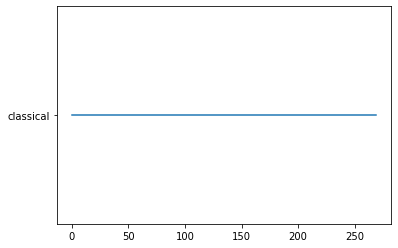

In [ ]:
data = ytimport("https://www.youtube.com/watch?v=9E6b3swbnWg", "classical")
print("Classical")
test_loss, f1_, acc_, confmatrix = testing(data, costfun, bestmodel)
plt.plot(infrence(data, bestmodel))
print(f"Accuracy is: {acc_} and f1 score is: {f1_}")

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


hiphop
Accuracy is: 6.88622754491018 and f1 score is: 0.0


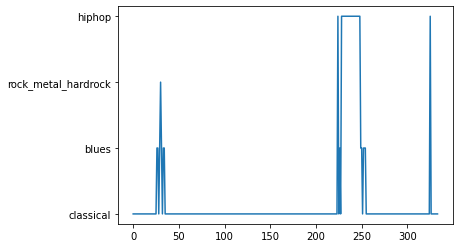

In [ ]:
data = ytimport("https://www.youtube.com/watch?v=EDwb9jOVRtU", "hiphop")
print("hiphop")
test_loss, f1_, acc_, confmatrix = testing(data, costfun, bestmodel)
plt.plot(infrence(data, bestmodel))
print(f"Accuracy is: {acc_} and f1 score is: {f1_}")

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


rock_metal_hardrock
Accuracy is: 0.0 and f1 score is: 0.0


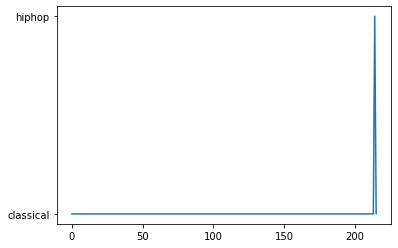

In [ ]:
data = ytimport("https://www.youtube.com/watch?v=OMaycNcPsHI", "rock_metal_hardrock")
print("rock_metal_hardrock")
test_loss, f1_, acc_, confmatrix = testing(data, costfun, bestmodel)
plt.plot(infrence(data, bestmodel))
print(f"Accuracy is: {acc_} and f1 score is: {f1_}")

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


blues
Accuracy is: 1.5974440894568689 and f1 score is: 0.0


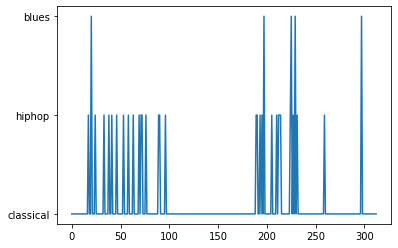

In [ ]:
data = ytimport("https://www.youtube.com/watch?v=l45f28PzfCI", "blues")
print("blues")
test_loss, f1_, acc_, confmatrix = testing(data, costfun, bestmodel)
plt.plot(infrence(data, bestmodel))
print(f"Accuracy is: {acc_} and f1 score is: {f1_}")

In [ ]:
test_loss, f1_, acc_, confmatrix = testing(test_dataloader, costfun, bestmodel)
print(f"Accuracy is: {acc_} and f1 score is: {f1_}")

Accuracy is: 78.125 and f1 score is: 0.7836589813232422


We see that the results are really biased towards classical music. This is not expected behavior since the model is in evaluation mode and won't learn from testing (model.eval()). Perhaps better regularisation would fix the issus as well as a bigger batch size (more than 1 that is at the moment to accomodate the infrence function).

Let us compare the results for each song:


*   classical: It is accurate, no questions there. It got all the labels right. The track is a good representation of classical music and it was an easy guess.
*   hiphop: The first seconds are wierd since there is no music, so the classical classification is unexpected. In addition the song brought back childhood memories, thank you for reminding its existance. The model did a really poor job guessing except from the seconds 225 to 250 that guessed correct. During those seconds there are no lyrics and just music that may have helped in the correct guessing.
*   rock: So the model did get nothing right. Somewhat impressive... The Placebo band's wikipedia page should be updated that the band plays classical music whith a hair of hiphop.
*   blues: The model also didnt do so well here. This time it wasnt stuck on classical but also guessed some seconds correctly. 


Last to make sure the model didnt become overfitted while testing the classical music, I tested the model with the test dataset after the predictions from youtube and I got the same result before the predictions just after the training.
